# Training on accessibility data from wheelmap.org using ResNet

### 0. Step: Install fast.ai compatible torch version

In [ ]:
!pip uninstall torch torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0

Uninstalling torch-1.7.0+cu101:
  Successfully uninstalled torch-1.7.0+cu101
Uninstalling torchvision-0.8.1+cu101:
  Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 47.1MB/s 


### 1. Step: Import required libraries

In [ ]:
from fastai.vision import *

### 2. Step: Download images from hyperlinks

#### 2.1. Step: Create folder structure

In [ ]:
labels = ['0', '1']
path = Path('data/accessibility')

for l in labels:
  dest = path/l
  dest.mkdir(parents=True, exist_ok=True)

#### 2.2. Step: Manually upload url files to `data/accessibility` folder

#### 2.3. Step: Actually download images

In [ ]:
for l in labels:
  file_name = 'accessibility_' + str(l) + '.txt'
  download_images(path/file_name, path/l, max_pics=1000)
  verify_images(path/l, delete=True)

cannot identify image file <_io.BufferedReader name='data/accessibility/1/00000534.jpg'>
cannot identify image file <_io.BufferedReader name='data/accessibility/1/00000535.jpg'>
cannot identify image file <_io.BufferedReader name='data/accessibility/1/00000533.jpg'>
cannot identify image file <_io.BufferedReader name='data/accessibility/1/00000540.jpg'>
cannot identify image file <_io.BufferedReader name='data/accessibility/1/00000536.jpg'>
cannot identify image file <_io.BufferedReader name='data/accessibility/1/00000537.jpg'>


In [ ]:
help(verify_images)

Help on function verify_images in module fastai.vision.data:

verify_images(path:Union[pathlib.Path, str], delete:bool=True, max_workers:int=4, max_size:int=None, recurse:bool=False, dest:Union[pathlib.Path, str]='.', n_channels:int=3, interp=2, ext:str=None, img_format:str=None, resume:bool=None, **kwargs)
    Check if the images in `path` aren't broken, maybe resize them and copy it in `dest`.



### 3. Step: Create ImageDataBunch

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Union[Collection[fastai.vision.image.Transform], NoneType]=None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



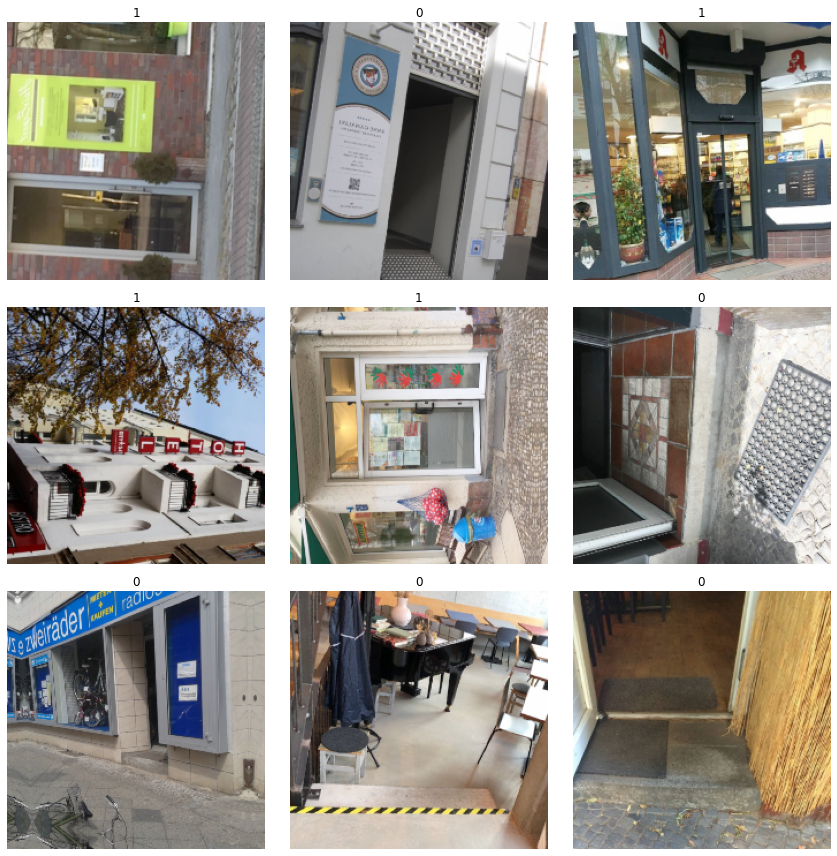

In [ ]:
data.show_batch(rows=3)

In [10]:
len(data.train_ds), len(data.valid_ds)

(1552, 387)

### 4. Step: Train ResNet34

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


#### 4.1. Step: Stage 1 training

In [12]:
learn.fit_one_cycle(4)

In [13]:
learn.save('stage-1')

#### 4.2. Step: Stage 2 training

In [14]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


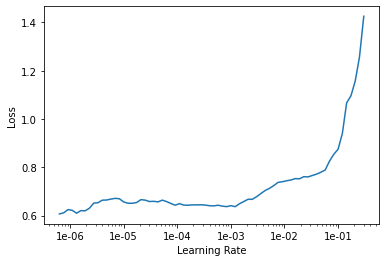

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(2, max_lr=slice(3e-5, 3e-4))

In [18]:
learn.save('stage-2')

### 5. Step: Interpret results

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

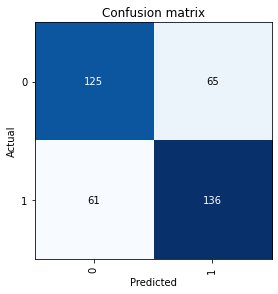

In [20]:
interp.plot_confusion_matrix()

In [21]:
from fastai.widgets import *

In [22]:
losses,idxs = interp.top_losses()

In [25]:
top_loss_paths = data.valid_ds.x[idxs]

In [26]:
fd = FileDeleter(file_paths=top_loss_paths)

NameError: ignored

In [30]:

help(interp.plot_top_losses)

Help on method _cl_int_plot_top_losses in module fastai.vision.learner:

_cl_int_plot_top_losses(k, largest=True, figsize=(12, 12), heatmap:bool=False, heatmap_thresh:int=16, alpha:float=0.6, cmap:str='magma', show_text:bool=True, return_fig:bool=None) -> Union[matplotlib.figure.Figure, NoneType] method of fastai.train.ClassificationInterpretation instance
    Show images in `top_losses` along with their prediction, actual, loss, and probability of actual class.



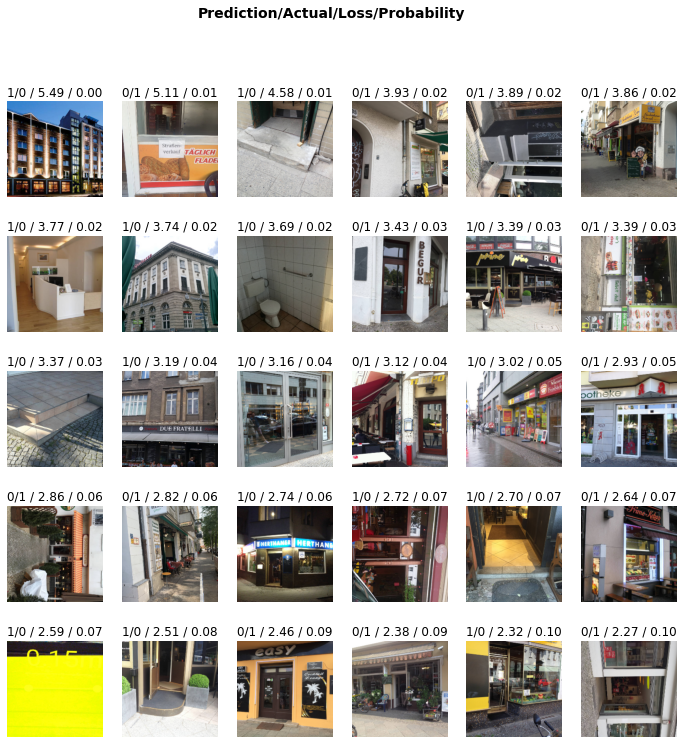

In [33]:
interp.plot_top_losses(30)